Tutorial: https://www.analyticsvidhya.com/blog/2021/05/sms-spam-detection-using-lstm-a-hands-on-guide/

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf

Unpreprocessed file: merged_cleaned.csv
(not executable on Colab beacause of to little RAM, not executable on own machine since it takes for ever...)

In [116]:
image_folder = 'Images/lstm_merged_cleaned/'
data_path = '../Data/merged_cleaned.csv'
image_title_info = '[merged_cleaned.csv]: '

spam_preprocessed.csv:

In [23]:
image_folder = 'Images/lstm_spam_preprocessed/'
data_path = '../../Data/preprocessed/spam_preprocessed.csv'
image_title_info = '[spam_preprocessed.csv]: '

enron_prep.csv:

In [55]:
image_folder = 'Images/lstm_enron_preprocessed/'
data_path = '../../Data/preprocessed/enron_preprocessed.csv'
image_title_info = '[enron_preprocessed.csv]: '

#MAIN:

In [56]:
df = pd.read_csv(data_path, encoding = "latin-1")
df.head()

,label,transformed_text
0,0,calpin daili ga nomin calpin daili ga nomin doc
1,0,issu fyi see note alreadi done stella forward ...
2,0,meter nov alloc fyi forward lauri allen hou ec...
3,0,mcmullen ga jacki sinc inlet river plant shut ...
4,0,meter jan georg need follow done jan zero rece...


In [57]:
df.shape

(23293, 2)

#Drop Null values:
Somehow it did not work to drop NULL values in preprocessing... Out of any reason there are some null falues in the data after reading the CSV even though they have not been there before writing the CSV file in the preprocessing skript!

In [58]:
df.isnull().sum()

label               0
transformed_text    3
dtype: int64

In [59]:
df.dropna(inplace=True)
df.isnull().sum()

label               0
transformed_text    0
dtype: int64

#Balancing Dataset: 

In [60]:
df_spam = df[df['label'] == 1]
df_ham  = df[df['label'] == 0]
print("Ham Dataset Shape:", df_ham.shape)
print("Spam Dataset Shape:", df_spam.shape)


Ham Dataset Shape: (11928, 2)
Spam Dataset Shape: (11362, 2)


In [61]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(11362, 2)

In [62]:
df = pd.concat([df_spam, df_ham_downsampled])

<AxesSubplot:xlabel='label', ylabel='count'>

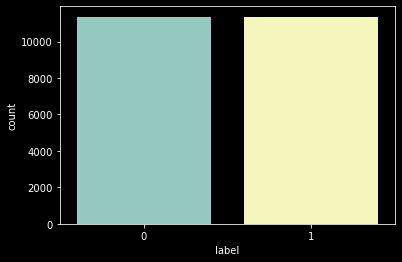

In [63]:
import seaborn as sns
sns.countplot(x=df["label"])

#Convert tokens into a numerical sequence:

In [64]:
#X=df["text"]
X=df["transformed_text"]
tokenizer = Tokenizer() #initializing the tokenizer
tokenizer.fit_on_texts(X)# fitting on the sms data
text_to_sequence = tokenizer.texts_to_sequences(X) # creating the numerical sequence

In [65]:
#tokenizer.index_word

In [66]:
len(tokenizer.index_word)

75388

We do have 130427 unique words!

In [67]:
#for i in range(3):
#        print("Text               : ",X[i] )
#        print("Numerical Sequence : ", text_to_sequence[i])

#Depending on the data this could fail since the index 0..2 could have been dropped in balancing the data! 

#Normalization:
Since all the messages are of different lengths also the sequences are of different length, so we have to padding the sequences with 0 to get equal length. Otherwise the sequences would not be compatible for the model!

In [68]:
max_length_sequence = max([len(i) for i in text_to_sequence]) # finding the length of largest sequence
padded_sequence = pad_sequences(text_to_sequence, maxlen=max_length_sequence, padding = "pre")
padded_sequence

array([[    0,     0,     0, ...,   360,   113,   424],
       [    0,     0,     0, ...,   906, 36994, 36995],
       [    0,     0,     0, ...,   156,   341,  2230],
       ...,
       [    0,     0,     0, ...,  6130,  1070,  1384],
       [    0,     0,     0, ...,   118,   154,    68],
       [    0,     0,     0, ...,    64,    43,   478]], dtype=int32)

The longest Sentence exists of 501

In [69]:
print("shape",len(padded_sequence), "rows x ",len(padded_sequence[0]),"cols")

shape 22724 rows x  348 cols


#Create LSTM Model:

In [70]:
TOT_SIZE = len(tokenizer.word_index)+1


def create_model():
      lstm_model = Sequential()
      lstm_model.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
      lstm_model.add(LSTM(100))
      lstm_model.add(Dropout(0.4))
      lstm_model.add(Dense(20, activation="relu"))
      lstm_model.add(Dropout(0.3))
      lstm_model.add(Dense(1, activation = "sigmoid"))
      return lstm_model

Metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
           ]

lstm_model = create_model()
lstm_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics=Metrics)

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 348, 32)           2412448   
                                                                 
 lstm_2 (LSTM)               (None, 100)               53200     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 20)                2020      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,467,689
Trainable params: 2,467,689
No

#Train Test Validation Split

In [71]:
from sklearn.model_selection import train_test_split
X=padded_sequence
y=df["label"]
X_train, X_val,  y_train, y_val  = train_test_split(X, y, test_size=0.7, random_state=42)
X_val,   X_test, y_val,   y_test = train_test_split(X_val, y_val, train_size=0.5)

#Train the model: 

In [72]:
from keras.callbacks import EarlyStopping

num_epochs = 10 #10!

history = lstm_model.fit(
               X_train ,
               y_train,
               epochs=num_epochs,
               validation_data=(X_val, y_val),
               #callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)]
          )

Epoch 1/10
214/214 [==============================] - 38s 171ms/step - loss: 0.3780 - accuracy: 0.8397 - precision: 0.8425 - recall: 0.8338 - val_loss: 0.0941 - val_accuracy: 0.9730 - val_precision: 0.9879 - val_recall: 0.9580
Epoch 2/10
214/214 [==============================] - 36s 169ms/step - loss: 0.1036 - accuracy: 0.9712 - precision: 0.9584 - recall: 0.9850 - val_loss: 0.0909 - val_accuracy: 0.9698 - val_precision: 0.9585 - val_recall: 0.9825
Epoch 3/10
214/214 [==============================] - 36s 170ms/step - loss: 0.0535 - accuracy: 0.9862 - precision: 0.9867 - recall: 0.9856 - val_loss: 0.0522 - val_accuracy: 0.9815 - val_precision: 0.9763 - val_recall: 0.9872
Epoch 4/10
214/214 [==============================] - 36s 169ms/step - loss: 0.0095 - accuracy: 0.9981 - precision: 0.9979 - recall: 0.9982 - val_loss: 0.0488 - val_accuracy: 0.9834 - val_precision: 0.9792 - val_recall: 0.9880
Epoch 5/10
214/214 [==============================] - 36s 167ms/step - loss: 0.0035 - accura

#SAVE MODEL AS PICKLE FILE: 

In [78]:
#import pickle
#pickle.dump(lstm_model, open("lstm_model_1.pkl", "wb"))

#Evaluation: 

In [79]:
#scores = lstm_model.evaluate(X_test, y_test, verbose=0)
#print("Test Accuracy: %.2f%%" % (scores[1]*100))

In [80]:
y_pred = lstm_model.predict(X_test)
y_pred = y_pred.flatten() 
y_pred = np.where(y_pred > 0.5, 1, 0) #Why? 

#y_test = y_test.to_numpy()
#Time: 1min 30s

Confusion Matrix: 

In [81]:
from sklearn.utils import check_matplotlib_support
from sklearn.utils.validation import check_memory
from sklearn.metrics import confusion_matrix, classification_report

In [82]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3986
           1       0.99      0.98      0.98      3968

    accuracy                           0.98      7954
   macro avg       0.98      0.98      0.98      7954
weighted avg       0.98      0.98      0.98      7954



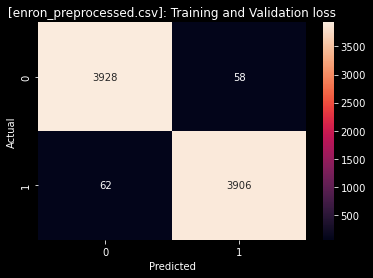

In [83]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title(image_title_info+'Training and Validation loss')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(image_folder+'cm.png')
plt.show()

Loss:

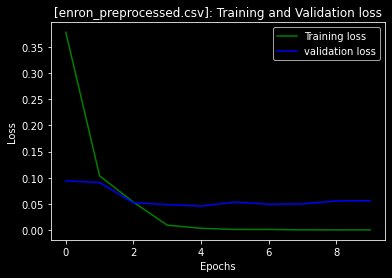

In [84]:
#epochs = range(1, num_epochs+1)
plt.plot(history.history['loss'], 'g', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='validation loss')
plt.title(image_title_info+'Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(image_folder+'loss.png')
plt.show()

Accuracy: 

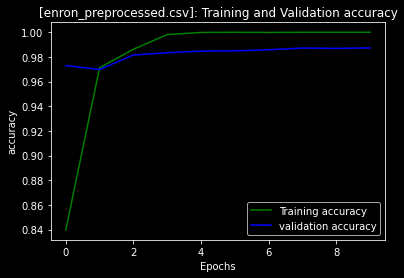

In [85]:
plt.plot( history.history['accuracy'], 'g', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='validation accuracy')
plt.title(image_title_info+'Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig(image_folder+'accuracy.png')
plt.show()

Precission:

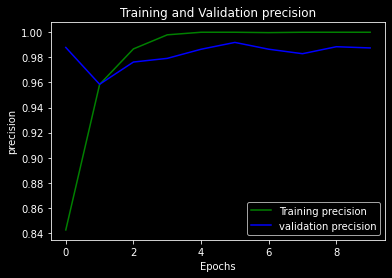

In [86]:
epochs = range(1, num_epochs+1)
plt.plot(history.history['precision'], 'g', label='Training precision')
plt.plot(history.history['val_precision'], 'b', label='validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()
plt.savefig(image_folder+'precision.png')
plt.show()